# SA-OT Model (With Iterated Learning) of Jespersen's Cycle - A Replication of Lopopolo & Biro (2011)

## Model Overview
SA-OT (Simulated Annealing for Optimality Theory) extends classical Optimality Theory (OT) -- a model of linguistic competence -- by integrating a stochastic search algorithm that models linguistic performance. 
As such, it relies on the basic components of standard OT:
- a **candidate set** of linguistic forms, and
- a set of **constraints**, ranked into **hierarchies** that represent different grammars.

In addition, it introduces two new elements that allows modeling performance variation:
- a **neighborhood structure (topology)** that organizes the candidate set by structural similarity, and
- a **search algorithm** -- specifically, simulated annealing -- that performs a random walk through this candidate space, guided by a harmony function derived from the constraint hierarchy.

Since the search is stochastic, SA-OT does not always find the globally optimal candidate, i.e., the grammartical form. Instead, it might settle on local optima -- suboptimal outputs, e.g., errors arising from fast speech, slips of the tongue, or tolerable irregularities. This is how SA-OT models linguistic performance, not just idealized grammatical competence thus accounts for linguistic variation and change. 

# Model Components & Setup

## Libraries & Global Variables

In [195]:
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Candidates & Topology

A **candidate** is a pair of underlying form and surface form (uf, sf):
- **uf**: represents the semantics, i.e., the polarity of the utterance -- *positive* or *negative*; 
- **sf**: a *binary syntactic tree*, composed of a main verb (V) and zero or more sentential negation markers (SN). 

Note: We are only interested in negative uf.

In [196]:
# ----- Utility functions for candidate formatting -----
def flatten(sf):
    """Utility to flatten nested list trees using recursion.
    
    This is because candidate surface forms with the same linear structure
    are assigned the same number of violation marks by all constraints. 
    
    Args:
        sf (list or str): The surface form, which can be a nested list or the 'V' string.

    Returns:
        list: A flat list of surface form string elements.
    """
    if isinstance(sf, str):
        return [sf]
    elif isinstance(sf, list):
        return [item for sublist in sf for item in flatten(sublist)]
    else:
        return []

def flatten_singletons(x):
    """Recursively flatten singleton lists, including nested ones.
    Examples:
        [['V']]           -> 'V'
        ['SN', ['V']]     -> ['SN', 'V']
        [[['SN']], [['V']]] -> ['SN', 'V']
    """
    # Flatten the top level if it's a singleton list
    while isinstance(x, list) and len(x) == 1:
        x = x[0]

    # If it's still a list, apply recursively to each element
    if isinstance(x, list):
        return [flatten_singletons(elem) for elem in x]
    else:
        return x


def prettify_sf(sf, flat=False):
    """Recursively convert nested lists to string with bracketed nested or linear structure."""
    if flat:
        sf = flatten(sf)
    if isinstance(sf, (tuple, list)):
        return "[" + " ".join(prettify_sf(sub) for sub in sf) + "]"
    return str(sf)
# ------------------------------------------


# ----- Example candidate surface forms and their formatting -----
SF_EXAMPLES = [
    'V',
    ['V'],
    ['SN', 'V'],
    ['V', 'SN'],
    [['SN', [['V', 'SN']]]],
    [['V', 'SN'], 'SN'],
    ['SN', ['SN', 'V']],
    [[['SN', 'V'], 'SN'], 'SN'],
]

sf = SF_EXAMPLES[4]
print(f"         Original sf: {sf}")
print(f"     Flat singletons: {flatten_singletons(sf)}")
print(f"        Flattened sf: {flatten(sf)}")
print(f"Prettified nested sf: {prettify_sf(sf, flat=False)}")
print(f"  Prettified flat sf: {prettify_sf(sf, flat=True)}")

         Original sf: [['SN', [['V', 'SN']]]]
     Flat singletons: ['SN', ['V', 'SN']]
        Flattened sf: ['SN', 'V', 'SN']
Prettified nested sf: [[SN [[V SN]]]]
  Prettified flat sf: [SN V SN]


The **neighbors** of a candidate are candidates whose sf's are the results of transforming the original candidate's sf via the following basic steps: 
1. Add an SN at the beginning (left side);
2. Add an SN at the end (right side);
3. Remove the outermost SN;
4. Reverse the order of any daughter nodes (e.g., turn [SN, V] into [V, SN]).

Note: the neighborhood structure (topology) is thus infinite. 

In [197]:
# ----- Neighborhood generation -----
def generate_neighbors(sf):
    """Generate neighborhood sf's of a candidate. 

    Args:
        sf (list or str): Surface form as nested list (or 'V' string).

    Returns:
        list of lists (or str): Neighbor candidates as nested lists (or 'V' string).
    """
    # Validate input
    assert isinstance(sf, (list, str)), "Input must be a list or the string 'V'."
    if isinstance(sf, str) and sf != 'V':
        raise ValueError("Input must be 'V' or a (nested) list.")    
    
    # Process input surface form
    sf = flatten_singletons(sf)

    neighbors = []

    # Basic step 1: Add 'SN' at beginning
    neighbors.append(['SN', sf])
    # Basic step 2: Add 'SN' at end
    neighbors.append([sf, 'SN'])

    # Basic step 3: Remove outermost SN        
    if sf[0] == 'SN':
        n = sf[1:]
        n = flatten_singletons(n) if len(n) == 1 else n 
        neighbors.append(n)
    elif sf[-1] == 'SN':
        n = sf[:-1]
        n = flatten_singletons(n) if len(n) == 1 else n
        neighbors.append(n)

    # Basic step 4a: Reverse any subtree
    for i, subtree in enumerate(sf):
        if not isinstance(subtree, str) and len(subtree) > 1:
            reversed_sub = subtree[::-1]
            new_sf = sf[:i] + [reversed_sub] + sf[i+1:]
            neighbors.append(new_sf)
    
    # Basic step 4b: Reverse top-level daughters if more than 1
    if not isinstance(sf, str) and len(sf) > 1:
        neighbors.append(sf[::-1])

    # neighbors = [list_to_tuple(n) for n in neighbors] NOTE: commented
    
    return neighbors
# --------------------------------------


# ----- Example usage -----
# NOTE: Compare with neighborhood space in Figure 3 (p. 30) in Lopolopo and Biro (2011).
c = 'V'
c = ['V']
c = ['SN', 'V']
# c = [['SN', 'V'], 'SN'] 
neighbors = generate_neighbors(c)
print("Neighbors of candidate:", prettify_sf(c, flat=False))
for n in neighbors:
    print(" -", prettify_sf(n, flat=False)) 

Neighbors of candidate: [SN V]
 - [SN [SN V]]
 - [[SN V] SN]
 - V
 - [V SN]


## Grammar: Constraints, Hierarchies & K-Values

The grammar is defined based on a set of violable constraints, which express preferences or requirements on surface forms.

There are four constraints, directly based on de Swart (2010):
- **Faith\[Neg]**: The polarity (uf) of the candidate must match the presence or absence of SN in the sf. Assigns 1 violation mark for a mismatch. 
    - Note: Since the input will only be negative polarity, 1 mark is given if there is no SN in the candidate sf. 
- **\*Neg**: Punishes every occurrence of SN in the sf, assigning as many violation marks as number of SN in the sf.
- **NegFirst**: Assigns 1 violation mark if candidate has no preverbal SN.
- **NegLast** (FocusLast in de Swart): Assigns 1 violation mark if candidate has no postverbal SN.

In [198]:
# ----- Constraint functions -----
def faith_neg(sf):
    """Faith[Neg]: (Faithfulness constraint) Penalize if negation is not expressed in surface form"""
    return 0 if 'SN' in flatten(sf) else 1

def star_neg(sf):
    """*Neg: (Markedness constraint) Penalize for every negation marker"""
    return flatten(sf).count('SN')

def neg_first(sf):
    """NegFirst: (Markedness constraint) Penalize if no negation at beginning"""
    return 0 if flatten(sf)[0] == 'SN' else 1

def neg_last(sf):
    """NegLast: (Markedness constraint) Penalize if no negation at end"""
    return 0 if flatten(sf)[-1] == 'SN' else 1
# --------------------------------- 


# ----- Constraint set -----
CONSTRAINTS_LIST = [faith_neg, star_neg, neg_first, neg_last]

# ----- Constraint evaluation -----
def eval_constraints(sf, constraints=CONSTRAINTS_LIST):
    """Evaluate a given surface form against all constraints in the specified list.

    Args:
        sf (list or str): Surface form as nested list (or 'V' string).
        constraints (list): List of constraint functions to apply.

    Returns:
        list: List of violation counts for each constraint in order.
    """
    return [c(sf) for c in constraints]
# --------------------------------

#  ----- Examples -----
candidate_sfs = [
    ['V'],
    ['SN', 'V'],
    ['V', 'SN'],
    ['SN', 'V', 'SN'],
    ['V', 'SN', 'SN'],
    ['SN', 'SN', 'V'],
    ['SN', 'V', 'SN', 'SN'],
]

results = {}

for sf in candidate_sfs:
    violations = eval_constraints(sf)
    results[prettify_sf(sf, flat=True)] = {CONSTRAINTS_LIST[i].__name__: violations[i] for i in range(len(CONSTRAINTS_LIST))}

df = pd.DataFrame.from_dict(results, orient='index')
df = df.fillna(0).astype(int)
print("Constraint violations of candidate sf's given the input 'uf = negative':\n (compare with Lopopolo & Biro, 2011, p. 29)")
display(df)


Constraint violations of candidate sf's given the input 'uf = negative':
 (compare with Lopopolo & Biro, 2011, p. 29)


,faith_neg,star_neg,neg_first,neg_last
[V],1,0,1,1
[SN V],0,1,0,1
[V SN],0,1,1,0
[SN V SN],0,2,0,0
[V SN SN],0,2,1,0
[SN SN V],0,2,0,1
[SN V SN SN],0,3,0,0


These constraints are ranked in **hierarchies** and assigned **ranking values (K-values)**, such that the higher the position of a constraint in a hierarchy, the higher its ranking value, and thus the more costly its violation. These constraints rakings represent the possible grammars/language variants.

In [199]:
# ----- Hierarchies and K-values -----
HIERARCHIES_DICT = {
    "H1": [faith_neg, star_neg, neg_first, neg_last],  # preverbal pure
    "H2": [faith_neg, neg_first, star_neg, neg_last],  # preverbal mixed
    "H3": [faith_neg, neg_first, neg_last, star_neg],  # discontinuous (left)
    "H4": [faith_neg, neg_last, neg_first, star_neg],  # discontinuous (right)
    "H5": [faith_neg, neg_last, star_neg, neg_first],  # postverbal mixed
    "H6": [faith_neg, star_neg, neg_last, neg_first]   # postverbal pure
}

K_VALUES_DEFAULT = [4, 3, 2, 1] # NOTE: These are values ASSOCIATED with the ranks 
                                #       (NOT the ranks themselves), such that
                                #       the higher the rank, the higher the K-value.
                                #       The rank is given by the index of the K-value in the list.
                                #       For example, K_VALUES[0] = 4 means that the highest ranked constraint (with index 0) has K-value 4,
                                #       and K_VALUES[-1] = 1 means that the lowest ranked constraint (with index -1) has K-value 1.


## Harmony & SA-OT

In OT, the optimal form given a grammar (i.e., a constraint hierarchy) is determined by the **harmony function**, which compares the constraint violations of the candidates in the candidate set. The candidate which best satisfies the constraints is the one that minimizes the number of violations of higher-ranked constraints. Thus the harmony function in OT always finds the optimal form given the grammar. Note that this requires that the candidate set be finite. 

On the other hand, SA-OT models linguistic performance by searching for the best candidate in the candidate topology given a grammar. Thus, performance emerges from the topology (which may be infinite) and the search algorithm heuristic. The search algorithm used in SA-OT is **simulated annealing (SA)**. It consists in a **random walk** over the topology, starting from one candidate and exploring its neighbors. The search is guided by the harmony function, i.e., how well each form satisfies the grammar (thus the random walk becomes hill climbing where the horizontal component is the search space of candidates defined by the neighborhood function and the vertical component is the harmony function). At each step, the algorithm:
- Picks a random neighbor;
- Compares the harmony of the initial candidate and the chosen neighbor:
	- If the neighbor is equally good or better, move to it;
	- If the neighbor is worse, decide whether to move to it based on a transition probability function, which depends on a temperature parameter.
- Controls the exploration with a temperature parameter:
	- At the start, the temperature is high, so the algorithm explores widely -- even worse options.
	- Over time, the temperature cools, and the algorithm becomes more selective (moves only to better neighbors).
	- Stops when no better neighbors are accepted -> a local optimum has been reached.

In [200]:
# ----- Simulated Annealing Algorithm -----
def sa_ot(initial_sf, grammar, 
          K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50,
          verbose=False):
    """Run simulated annealing with optimality theory.

    Args:
        initial_sf (str): The initial surface form.
        grammar (dict): A dictionary mapping constraints to their K-values.
        K_max (int, optional): The maximum K-value. Defaults to 5.
        K_step (int, optional): The step size for K. Defaults to 1.
        t_max (int, optional): The maximum temperature. Defaults to 3.
        t_min (int, optional): The minimum temperature. Defaults to 0.
        t_step (int, optional): The step size for temperature. Defaults to 1.
        max_no_moves (int, optional): The maximum number of moves without improvement. Defaults to 50.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        tuple: The final surface form after simulated annealing.
    """
    current = initial_sf

    # Iterate over temperature schedule
    K = K_max
    no_moves_count = 0
    iters = 0
    
    # Temperature K will decrease until max_no_moves is reached
    while no_moves_count < max_no_moves:
        # Iterate over t temperatures
        for t in np.arange(t_max, t_min, -t_step):
            iters += 1
            if verbose:
                print(f"\n>>> Iteration {iters}, K={K}, t={t}, Current: {current}")
            
            # Randomly select a neighbor of the current candidate
            cand = random.choice(generate_neighbors(current))
            if verbose:
                print(f"Candidate: {cand}")
            
            # Find the fatal constraint
            sorted_grammar = sorted(grammar.items(), key=lambda x: x[1], reverse=True)
            sorted_constraints = [constraint for constraint, _ in sorted_grammar]
        
            for constraint in sorted_constraints:
                if verbose: 
                    print(f"Evaluating constraint: {constraint.__name__}")
                c_curr, c_cand = constraint(current), constraint(cand)
                if verbose:
                    print(f"Current: {c_curr}, Candidate: {c_cand}")
                if c_curr != c_cand:
                    no_fatal = False # Reset no_fatal flag
                    C = constraint
                    # Get the K-value for the fatal constraint
                    k_C = grammar[C]
                    # Calculate the difference in violations for the fatal constraint between current and candidate
                    d = c_cand - c_curr 
                    if verbose:
                        print(f"Fatal constraint: {C.__name__}, K-value: {k_C}, Difference: {d}")
                    break
                else:
                    no_fatal = True  # No fatal constraint found
            
            # Decide whether to move to the candidate
            e = 1e-9 if t == 0 else 0  # to avoid division by zero in probability calculation
            
            if d < 0 or no_fatal:  # if candidate is more harmonic or no fatal constraint (equal harmony)
                current = cand # move to not-less harmonic neighbor
                no_moves_count = 0 # reset no_moves if a move is made
                if verbose:
                    print("Moved to not-less harmonic neighbor.")
            
            else:
                if k_C < K:
                    current = cand # move to less harmonic neighbor if k-value of fatal constraint is lower than temperature K
                    no_moves_count = 0 # reset no_moves if a move is made
                    if verbose:
                        print(f"Moved to less harmonic neighbor because k_C={k_C} < K={K}.")
                elif k_C == K:
                    p = random.random()
                    if p < math.exp(-d / (t + e)):
                        current = cand # move to less harmonic neighbor with probability exp(-d / (t + e))
                        no_moves_count = 0 # reset no_moves if a move is made
                        if verbose:
                            print("Moved to less harmonic neighbor with because p={p} < exp(-d / (t + e)).")
                else:
                    no_moves_count += 1  # increase no_moves if no move is made
                    if verbose:
                        print("Did not move")
        
        K -= K_step  # Decrease K 
    
    if verbose:
        print(f"\nFinal candidate found after {iters} iterations.")
    
    if star_neg(current) > 2:
        print(f"Warning: Final candidate {current} has {star_neg(current)} *Neg violations (should be <= 2).")
    
    return current

In [201]:
# Example usage of simulated annealing with Optimality Theory
initial_sf = 'V'
hierarchy = HIERARCHIES_DICT['H1']
grammar = {c: K_VALUES_DEFAULT[i] for i, c in enumerate(hierarchy)}

print(f"Grammar: {' >> '.join(c.__name__ + f' (K={K})' for c, K in grammar.items())}")

sa_ot(initial_sf, grammar, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50, verbose=True)

Grammar: faith_neg (K=4) >> star_neg (K=3) >> neg_first (K=2) >> neg_last (K=1)

>>> Iteration 1, K=5, t=3, Current: V
Candidate: ['V', 'SN']
Evaluating constraint: faith_neg
Current: 1, Candidate: 0
Fatal constraint: faith_neg, K-value: 4, Difference: -1
Moved to not-less harmonic neighbor.

>>> Iteration 2, K=5, t=2, Current: ['V', 'SN']
Candidate: [['V', 'SN'], 'SN']
Evaluating constraint: faith_neg
Current: 0, Candidate: 0
Evaluating constraint: star_neg
Current: 1, Candidate: 2
Fatal constraint: star_neg, K-value: 3, Difference: 1
Moved to less harmonic neighbor because k_C=3 < K=5.

>>> Iteration 3, K=5, t=1, Current: [['V', 'SN'], 'SN']
Candidate: ['SN', [['V', 'SN'], 'SN']]
Evaluating constraint: faith_neg
Current: 0, Candidate: 0
Evaluating constraint: star_neg
Current: 2, Candidate: 3
Fatal constraint: star_neg, K-value: 3, Difference: 1
Moved to less harmonic neighbor because k_C=3 < K=5.

>>> Iteration 4, K=4, t=3, Current: ['SN', [['V', 'SN'], 'SN']]
Candidate: [['SN', [['

['SN', 'V']

# Exp.1: SA-OT On All Landscapes

Apply each hierarchy to the typology and evaluate the candidates -> obtain 6 landscapes on which to perform SA-OT hill climbing to search for optima. Perform the seach many times and compute the outcome proportions in each hierarchy. 

In [202]:
# ----- Running SA-OT for multiple hierarchies -----

def sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=K_VALUES_DEFAULT, n=1000, verbose=False):
    """Run SA-OT for multiple hierarchies and return results."""
    if verbose:
        print(f"Running SA-OT for {len(hierarchies)} hierarchies with {n} runs each...")
    
    results = {h: [] for h in hierarchies.keys()}
    
    for h_name, h in hierarchies.items():
        grammar = {c: k_values[i] for i, c in enumerate(h)}
        if verbose:
            print(f"Running SA-OT for {h_name}: {' >> '.join(c.__name__ + f' (K={K})' for c, K in grammar.items())}")
        for i in range(n):
            final_sf = sa_ot(initial_sf, grammar=grammar, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)
            results[h_name].append(final_sf)
    
    return results

results = sa_ot_multiple_runs(n=100, verbose=True)

Running SA-OT for 6 hierarchies with 100 runs each...
Running SA-OT for H1: faith_neg (K=4) >> star_neg (K=3) >> neg_first (K=2) >> neg_last (K=1)
Running SA-OT for H2: faith_neg (K=4) >> neg_first (K=3) >> star_neg (K=2) >> neg_last (K=1)
Running SA-OT for H3: faith_neg (K=4) >> neg_first (K=3) >> neg_last (K=2) >> star_neg (K=1)
Running SA-OT for H4: faith_neg (K=4) >> neg_last (K=3) >> neg_first (K=2) >> star_neg (K=1)
Running SA-OT for H5: faith_neg (K=4) >> neg_last (K=3) >> star_neg (K=2) >> neg_first (K=1)
Running SA-OT for H6: faith_neg (K=4) >> star_neg (K=3) >> neg_last (K=2) >> neg_first (K=1)


,H1,H2,H3,H4,H5,H6
[SN V],1.0,0.54,0.00,0.00,0.00,0.0
[SN [V SN]],0.0,0.46,0.45,0.63,0.00,0.0
[[SN V] SN],0.0,0.00,0.55,0.37,0.56,0.0
[V SN],0.0,0.00,0.00,0.00,0.44,1.0


<Figure size 1200x600 with 0 Axes>

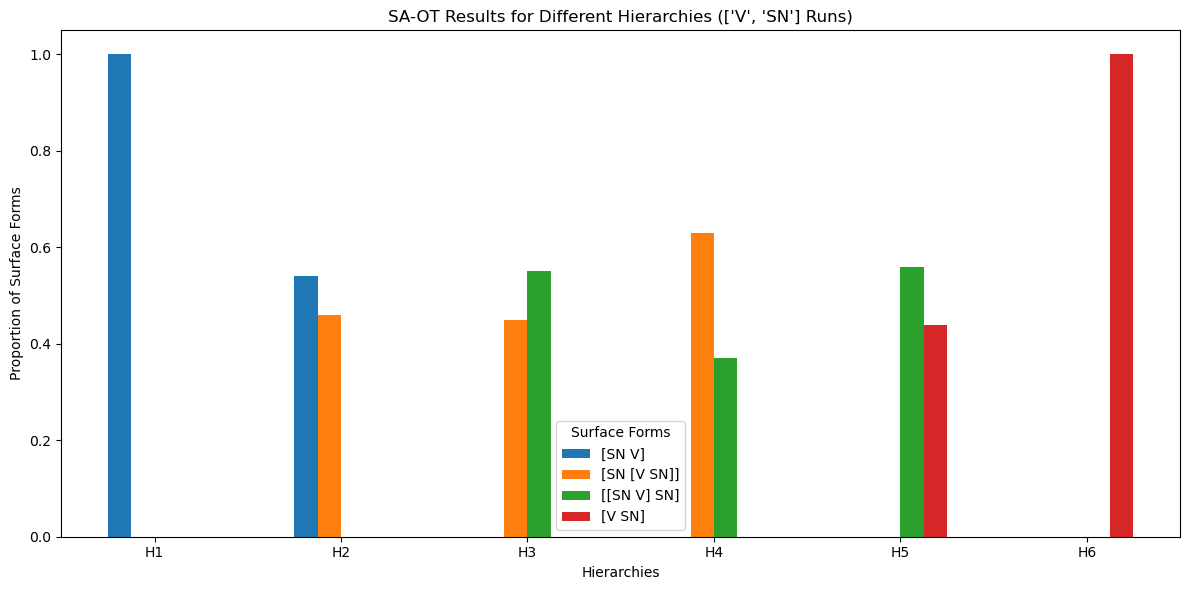

In [203]:
# ----- Analyzing results -----
def count_surface_forms(results, pretty=True, flat=False):
    """
    Count occurrences and calculate proportions of each surface form in the results.

    Args:
        results (dict): Dictionary mapping each hierarchy name to a list of surface forms.
        flatten_outputs (bool): Whether to flatten nested surface forms. 

    Returns:
        tuple:
            - results_count (dict): Raw counts of each surface form per hierarchy.
            - results_proportions (dict): Proportions of each surface form per hierarchy.
    """
    results_count = {h: {} for h in results.keys()}
    results_proportions = {}

    for h_name, sf_list in results.items():
        total = len(sf_list)
        
        for sf in sf_list:
            key = prettify_sf(sf, flat=flat) if pretty else sf
            results_count[h_name][key] = results_count[h_name].get(key, 0) + 1

        # Compute proportions
        results_proportions[h_name] = {
            sf: count / total for sf, count in results_count[h_name].items()
        }

    return results_count, results_proportions


# Count surface forms and calculate proportions
results_count, results_proportions = count_surface_forms(results, pretty=True, flat=False)


# ----- Visualizing results -----
# Convert results_proportions to a DataFrame for better visualization
results_df = pd.DataFrame(results_proportions).fillna(0)
display(results_df)

# Plotting the results
plt.figure(figsize=(12, 6))
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title(f'SA-OT Results for Different Hierarchies ({n} Runs)')
plt.xlabel('Hierarchies')
plt.ylabel('Proportion of Surface Forms')
plt.xticks(rotation=0)
plt.legend(title='Surface Forms')
plt.tight_layout()
plt.show()

## Different constraint K-values

Hierarchies 2 and 5 introduce both a global optimum (preverbal negation [SN V] and postverbal negation [V SN], respectively) and a local optimum (the forms of discontinuous negation [SN [V SN]] and [[SN V] SN], repsectively). Simulated annealing applied to these hierarchies produces the global optimum (the "grammatical form") with frequency `p`, and the other local optimum (the "performance errors") with frequency `1 − p`. Thus, `p` is the precision of SA-OT: the probability of finding the grammatical form. The value of this probability depends on the parameters of the algorithm. While `K_max` and `t_step` seem to have minimal impact according to Lopopolo and Biro, the athours find that reducing the ranking value of the lowest-ranked constraint makes the value of `p` vary from a bit over 0.5 to almost 1.0. This is what we test below. Note that from the point of view of traditional OT, decreasing the rank of the lowest ranked constraint does not change the grammar since the order of the constraints remains the same, and the harmony of the candidates are also unaffected. 

In [204]:
k_values_last = [i for i in range(1, -11, -1)]

all_results = {}

for k in k_values_last:
    n = 100  # Number of runs for each hierarchy
    print(f"Running {n} SA-OT simulations for k={k}...")
    k_values = np.array([4, 3, 2, k])
    results = sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=k_values, n=n, verbose=False)

    # Count surface forms and compute proportions
    _, results_proportions = count_surface_forms(results, pretty=True, flat=True)

    # Convert proportions to DataFrame
    all_results[k] = pd.DataFrame(results_proportions).fillna(0) 

Running 100 SA-OT simulations for k=1...
Running 100 SA-OT simulations for k=0...
Running 100 SA-OT simulations for k=-1...
Running 100 SA-OT simulations for k=-2...
Running 100 SA-OT simulations for k=-3...
Running 100 SA-OT simulations for k=-4...
Running 100 SA-OT simulations for k=-5...
Running 100 SA-OT simulations for k=-6...
Running 100 SA-OT simulations for k=-7...
Running 100 SA-OT simulations for k=-8...
Running 100 SA-OT simulations for k=-9...
Running 100 SA-OT simulations for k=-10...


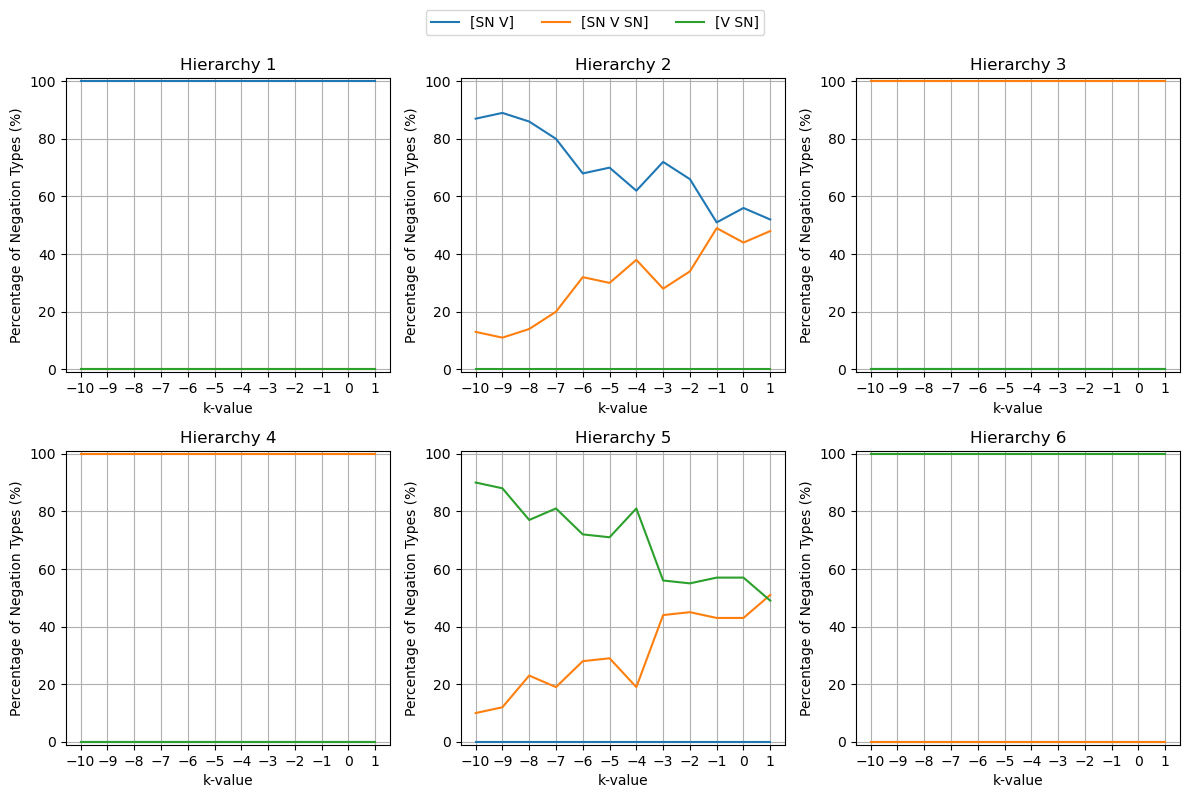

In [205]:
# ----- Plotting the results for each hierarchy across k-values -----

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Go through each hierarchy and plot surface form proportions across k-values
for ax, (h_name, _) in zip(axes.flat, HIERARCHIES_DICT.items()):
    # Build a DataFrame: rows are k-values, columns are prettified surface forms
    df = pd.DataFrame({
        k: all_results[k][h_name] if h_name in all_results[k] else pd.Series()
        for k in k_values_last
    }).T.fillna(0)

    for sf in df.columns:
        ax.plot(k_values_last, df[sf] * 100, label=sf)

    ax.set_title(f'Hierarchy {h_name[-1]}')  # \n{">>".join(c.__name__ for c in HIERARCHIES_DICT[h_name])}
    ax.set_xlabel('k-value')
    ax.set_ylabel('Percentage of Negation Types (%)')
    ax.set_xticks(k_values_last)
    ax.set_ylim(-1, 101)
    ax.grid(True)

# Create legend from last processed df (assuming all dfs share same surface forms)
fig.legend(labels=df.columns, loc='upper center', ncol=len(df.columns), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# Exp.2: ABM to Simulate Transition Between Stages

The frequencies of the different forms seems to be directly related to the rank values of the constraints. This makes it possible to learn from data with specific frequencies. 

This in turns allows to reproduce the change in dominant grammar on a population level across generations through an **iterated learning simulation** (Kirby & Hurford, 2002) where agents learn from the productions of the immediately preceding generation. 

## GLA

The iterated leaning simulation uses the **Gradual Learning Algoritm** (Boersma, 1997) to model the learning procedure. It works as follows:
When the learner's output differs from the observed target, the ranking values of the constraints are updated by:
- **increasing** the ranking of constraints that favor the target form, and
- **decreasing** the ranking of constraints that favor the learner's erroneous form.

In [207]:
def gla_update(grammar, predicted_sf, observed_sf, plasticity=0.1, update_ceiling=True):
    """
    Performs a single GLA update step.

    Args:
        grammar (dict): Mapping of constraints to their ranking values {constraint_function: float}
        predicted_sf (list): predicted surface form (nested or not)
        observed_sf (list): observed surface form (nested or not)
        plasticity (float): learning rate
        update_ceiling (bool): whether to ensure ranks do not exceed a ceiling value of the highest k-value

    Returns:
        dict: updated ranks (same structure as input)
    """
    updated_grammar = grammar.copy()
    
    if update_ceiling:
        # Ensure k-values do not exceed a ceiling value of the highest k-value in the initial grammar
        max_k = max(grammar.values()) 
    
    for constraint_fn in grammar:
        predicted_violations = constraint_fn(predicted_sf)
        observed_violations = constraint_fn(observed_sf)
        diff = observed_violations - predicted_violations

        if diff == 0:
            continue
        if diff > 0:
            updated_grammar[constraint_fn] -= plasticity
        else:
            updated_grammar[constraint_fn] += plasticity 
            # If applicable, ensure the new k-value does not exceed the ceiling value
            if update_ceiling and updated_grammar[constraint_fn] >= max_k:
                excessive_k = updated_grammar[constraint_fn]
                updated_grammar[constraint_fn] = max_k - 1e-9  # Set to just below the ceiling value
                print(f"WARNING: Rank of {constraint_fn.__name__} exceeded ceiling value of {max_k} ({excessive_k}) -> set to {max_k - 1e-9}")

    return updated_grammar


# ----- Utility functions -----
def grammar_dict_to_readable(grammar_dict):
    """Convert dict with function keys to dict with function name keys for display."""
    return {fn.__name__: k for fn, k in grammar_dict.items()}


def get_hierarchy_name(grammar):
    """Get the name of the current hierarchy based on the grammar."""
    sorted_grammar = sorted(grammar.items(), key=lambda x: x[1], reverse=True)
    sorted_constraints = [constraint for constraint, _ in sorted_grammar]
    
    for h_name, constraints in HIERARCHIES_DICT.items():
        if constraints == sorted_constraints:
            return h_name
    return "Unknown hierarchy"

# ---------------------------------


# ----- Example usage of GLA update -----
grammar = {faith_neg: 4.0, star_neg: 3.0, neg_first: 2.0, neg_last: 1.0}

print(f"Initial grammar:\t{grammar_dict_to_readable(grammar)}")
h_name = get_hierarchy_name(grammar)
hierarchy = HIERARCHIES_DICT[h_name]
k_values = [grammar[c] for c in hierarchy]
hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

for i in range(5):  # multiple updates
    grammar_updated = gla_update(
        grammar,
        predicted_sf=['SN', 'V'],
        observed_sf=['V', 'SN']
    )
    grammar = grammar_updated 
    print(f"\nGrammar after update {i + 1}: {grammar_dict_to_readable(grammar)}")
    h_name = get_hierarchy_name(grammar)
    hierarchy = HIERARCHIES_DICT[h_name]
    k_values = [grammar[c] for c in hierarchy]
    hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
    print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

Initial grammar:	{'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 2.0, 'neg_last': 1.0}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 2.0, 1.0]

Grammar after update 1: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.9, 'neg_last': 1.1}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.9, 1.1]

Grammar after update 2: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.7999999999999998, 'neg_last': 1.2000000000000002}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.7999999999999998, 1.2000000000000002]

Grammar after update 3: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.6999999999999997, 'neg_last': 1.3000000000000003}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.6999999999999997, 1.3000000000000003]

Grammar after update 4: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.5999999999999996, 'n

## Agent Class

In [208]:
class Agent:
    def __init__(self, id, hierarchy_name, seed=42):
        """An agent equipped with:
        - an OT grammar (the model of its competence): A set of constraints with associated K-values. 
                                                        The agent's grammar is initialized with random K-values between -0.1 and 4.9 
                                                        for the constraints in the order of the specified hierarchy 
                                                        (only the Faith[Neg] constraint is always initialized with a K-value of 4.9).
        - an SA-OT production procedure (performance): The agent can produce surface forms based on its grammar.
        - a GLA learning procedure (Boersma, 1997): The agent can update its grammat based on observed surface forms. 
        
        Args:
            id (int): Unique identifier for the agent.
            hierarchy_name (str): Name of the hierarchy to initialize the agent's grammar.
            seed (int, optional): Random seed for reproducibility. Defaults to 42.
        """
        self.id = id

        self.HIERARCHIES_DICT = {
            "H1": [faith_neg, star_neg, neg_first, neg_last],
            "H2": [faith_neg, neg_first, star_neg, neg_last],
            "H3": [faith_neg, neg_first, neg_last, star_neg],
            "H4": [faith_neg, neg_last, neg_first, star_neg],
            "H5": [faith_neg, neg_last, star_neg, neg_first],
            "H6": [faith_neg, star_neg, neg_last, neg_first]
        }
        
        self.initial_hierarchy_name = hierarchy_name  # for reference
        self.grammar = self.init_grammar(self.initial_hierarchy_name)

    def __repr__(self):
        """String representation of the agent."""
        return f"Agent(id={self.id}, hierarchy={self.hierarchy_name}, grammar={self.grammar_dict_to_readable(self.grammar)})"

    def init_grammar(self, hierarchy_name):
        """Initialize the agent's grammar based on the specified hierarchy."""
        assert hierarchy_name in self.HIERARCHIES_DICT, f"Invalid hierarchy name: {hierarchy_name}"
        
        # Initialize K-values randomly for the constraints in the hierarchy (ensuring Faith[Neg] is always 4.9)
        init_k_values = sorted([4.9] + [random.uniform(-0.1, 4.9) for _ in range(3)], reverse=True)
        grammar = {constraint: k for constraint, k in 
                        zip(self.HIERARCHIES_DICT[hierarchy_name], init_k_values)}
        return grammar

    def grammar_dict_to_readable(self, grammar_dict):
        """Convert dict with function keys to dict with function name keys for display."""
        return {fn.__name__: rank for fn, rank in grammar_dict.items()}

    @property
    def hierarchy_name(self):
        """Dynamic property that returns current hierarchy name."""
        sorted_grammar = sorted(self.grammar.items(), key=lambda x: x[1], reverse=True)
        sorted_constraints = [constraint for constraint, _ in sorted_grammar]
        
        for h_name, h_constraints in self.HIERARCHIES_DICT.items():
            if h_constraints == sorted_constraints:
                return h_name
        return f"Unknown hierarchy: {self.grammar_dict_to_readable(self.grammar)}"
    
    def produce_sf(self):
        """Produce a surface form based on the agent's grammar."""        
        # Run SA-OT with current grammar state
        return sa_ot(initial_sf='V',
                     grammar=self.grammar,
                     K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)
    
    def learn_from(self, observed_sf):
        """Update the agent's grammar based on observed surface form."""
        # Predict surface form using SA-OT with current grammar state
        predicted_sf = self.produce_sf()
        
        # Update grammar based on comparison of predicted and observed sf
        if predicted_sf != observed_sf:
            updated_grammar = gla_update(grammar=self.grammar, predicted_sf=predicted_sf, observed_sf=observed_sf, plasticity=0.1)
            self.grammar = updated_grammar


# ----- Example usage of Agent -----
agent = Agent(id=0, hierarchy_name='H3')
print(f"Initial agent:\n\t{agent}")
agent.produce_sf()  # Produces a surface form based on the current grammar
observed_sf = ['SN', 'V']  # Example observed surface form
agent.learn_from(observed_sf)  # Update the agent's grammar based on the observed surface form
print(f"\nAgent after learning from observed surface form {observed_sf}:\n\t{agent}")


for i in range(5):  # Multiple iterations of learning
    agent.learn_from(observed_sf)  # Update based on the same observed surface form
    print(f"\nAgent after iteration {i + 1}:\n\t{agent}")

Initial agent:
	Agent(id=0, hierarchy=H3, grammar={'faith_neg': 4.9, 'neg_first': 2.970658893102109, 'neg_last': 1.2661763283073317, 'star_neg': 0.7503381919189812})

Agent after learning from observed surface form ['SN', 'V']:
	Agent(id=0, hierarchy=H3, grammar={'faith_neg': 4.9, 'neg_first': 2.970658893102109, 'neg_last': 1.1661763283073316, 'star_neg': 0.8503381919189812})

Agent after iteration 1:
	Agent(id=0, hierarchy=H3, grammar={'faith_neg': 4.9, 'neg_first': 2.970658893102109, 'neg_last': 1.0661763283073316, 'star_neg': 0.9503381919189812})

Agent after iteration 2:
	Agent(id=0, hierarchy=H2, grammar={'faith_neg': 4.9, 'neg_first': 2.970658893102109, 'neg_last': 0.9661763283073316, 'star_neg': 1.0503381919189811})

Agent after iteration 3:
	Agent(id=0, hierarchy=H2, grammar={'faith_neg': 4.9, 'neg_first': 2.970658893102109, 'neg_last': 0.8661763283073316, 'star_neg': 1.1503381919189812})

Agent after iteration 4:
	Agent(id=0, hierarchy=H2, grammar={'faith_neg': 4.9, 'neg_first

### Convergence Test

Convergence test simulating  SA-OT with iterated learning to measure how quickly new learner agents born with different grammars adopt the grammar of a teacher (adult) agent. The goal is to understand how stable a target grammar is (in this case, Hierarchy 1) under transmission through GLA-based learning. We analyze:
- How many learning iterations are needed for agents starting from different grammars to converge to H1.
- How consistent that convergence is across multiple independent simulations.
- Whether certain starting grammars (e.g., H2 vs. H6) make convergence easier or harder. 

Run 1/100...
Adult agent (H1): Agent(id=0, hierarchy=H1, grammar={'faith_neg': 4.9, 'star_neg': 2.9654788360200306, 'neg_first': 2.7155035515868, 'neg_last': 1.6532155945639826})
Agent H2 settled on H1 after 1 iterations with grammar: {'faith_neg': 4.9, 'neg_first': 1.0846966989378015, 'star_neg': 1.1548018629231223, 'neg_last': 0.06797685861224495}.
Agent H3 settled on H1 after 60 iterations with grammar: {'faith_neg': 4.9, 'neg_first': 4.830325892183464, 'neg_last': 1.4155623648710511, 'star_neg': 4.8481413257657175}.
Agent H4 settled on H1 after 11 iterations with grammar: {'faith_neg': 4.9, 'neg_last': 2.062885695726941, 'neg_first': 2.6157051353548644, 'star_neg': 2.652784756351852}.
Agent H5 settled on H1 after 11 iterations with grammar: {'faith_neg': 4.9, 'neg_last': 0.9164276802184564, 'star_neg': 1.3481889129306868, 'neg_first': 0.9499023922357313}.
Agent H6 settled on H1 after 2 iterations with grammar: {'faith_neg': 4.9, 'star_neg': 0.9382365123112276, 'neg_last': 0.7296078

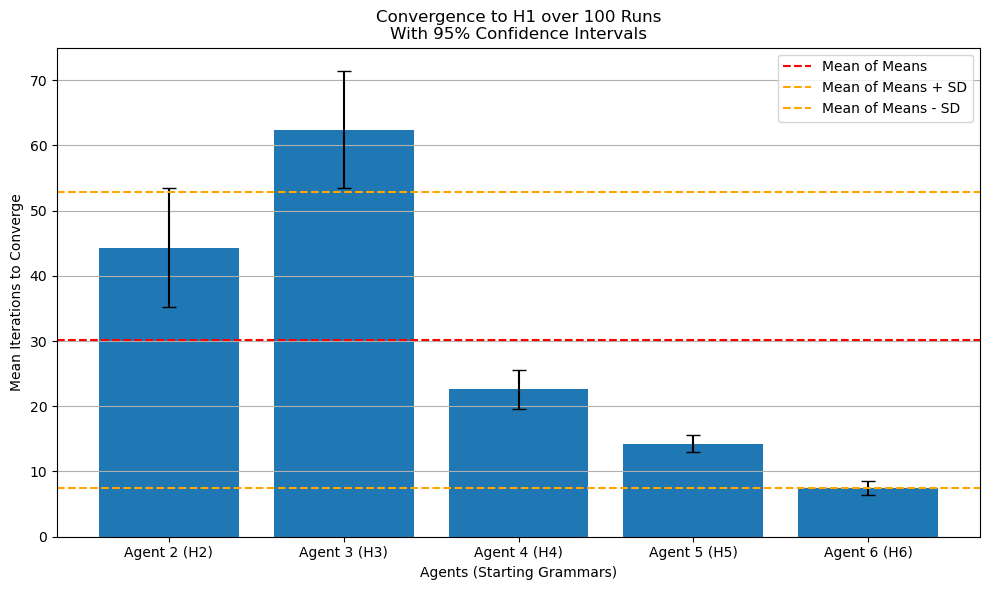

In [210]:
# ----- Parameters -----
n_runs = 100  # Number of runs for each agent/grammar
max_iters = 300
hierarchies = list(range(2, 7))  # H2 to H6
n_agents = len(hierarchies)
verbose = False # Set to True for detailed output

# Store convergence times: shape = (n_runs, n_agents)
all_learning_iters = np.zeros((n_runs, n_agents)) 

# ----- Run multiple simulations for each agent/grammar -----
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}...")
    adult_agent = Agent(id=0, hierarchy_name='H1')
    if verbose:
        print(f"Adult agent (H1): {adult_agent}")

    for j, h in enumerate(hierarchies):
        new_agent = Agent(id=h, hierarchy_name=f'H{h}')
        count = 0

        while new_agent.hierarchy_name != adult_agent.hierarchy_name:
            if count > max_iters:
                all_learning_iters[run, j] = np.nan  # failed to converge
                break
            count += 1
            observed_sf = adult_agent.produce_sf()
            new_agent.learn_from(observed_sf)
        if verbose:
            print(f"Agent {new_agent.initial_hierarchy_name} settled on {new_agent.hierarchy_name} after {count} iterations with grammar: {new_agent.grammar_dict_to_readable(new_agent.grammar)}.")

        if count <= max_iters:
            all_learning_iters[run, j] = count

# ----- Compute statistics -----
print(all_learning_iters)

means = np.nanmean(all_learning_iters, axis=0)
stds = np.nanstd(all_learning_iters, axis=0, ddof=1)
n_valid = np.sum(~np.isnan(all_learning_iters), axis=0)  # count of valid runs for each agent

# Compute standard error of the mean (SEM)
stderr = np.divide(stds, np.sqrt(n_valid), out=np.full_like(stds, np.nan), where=n_valid != 0)

# Compute 95% confidence intervals
conf_intervals = stats.t.interval(
    confidence=0.95,
    df=n_valid - 1,
    loc=means,
    scale=stderr
)
lower_ci = means - conf_intervals[0]
upper_ci = conf_intervals[1] - means

# Compute mean of means and standard deviation of means
mean_of_means = np.nanmean(means)
mean_std = np.nanstd(means, ddof=1)

# ----- Plot -----
x = np.arange(len(hierarchies))
plt.figure(figsize=(10, 6))
plt.bar(x, means, yerr=[lower_ci, upper_ci], capsize=5)
plt.xticks(x, [f'Agent {h} (H{h})' for h in hierarchies])
# Plot mean of means and standard deviation of means
plt.axhline(mean_of_means, color='red', linestyle='--', label='Mean of Means')
plt.axhline(mean_of_means + mean_std, color='orange', linestyle='--', label='Mean of Means + SD')
plt.axhline(mean_of_means - mean_std, color='orange', linestyle='--', label='Mean of Means - SD')
plt.legend()
plt.xlabel('Agents (Starting Grammars)')
plt.ylabel('Mean Iterations to Converge')
plt.title(f'Convergence to H1 over {n_runs} Runs\nWith 95% Confidence Intervals')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Model Class

In [211]:
class Model:
    def __init__(self, pop_size=5, generations=100, gen0_hierarchy_name='H1',
                 learning_data_size=300, productions_per_agent=100, seed=42):  
        
        self.pop_size = pop_size
        self.generations = generations
        self.gen0_hierarchy_name = gen0_hierarchy_name
        self.learning_data_size = learning_data_size
        self.productions_per_agent = productions_per_agent

        self.agents = []
        self.current_gen = 0
        
        self.production_history = {}
        self.initial_hierarchies = {}
        self.updated_hierarchies = {} 
        
        self.HIERARCHY_NAMES = [f"H{i}" for i in range(1, 7)]

    def init_pop(self):
        """Initialize a population of agents with specified initial hierarchy."""        
        for i in range(1, self.pop_size + 1):
            agent = Agent(i, hierarchy_name='H1')
            self.agents.append(agent)
    
    def step(self):
        """Perform a single step of the model (i.e., one generation):
        - create new generation of agents with randomly initialized grammars, 
        - adjust their grammars iteratively based on learning data from the previous generation, 
        - record a production sample from the new generation once learning is done,
        - replace the old generation with the new one.
        """       
        assert len(self.agents) > 0, "Population must be initialized before stepping."
        
        # Initialize new agents with a randomly chosen hierarchy
        self.current_gen += 1
        new_agents = []
        id_start = self.current_gen * len(self.agents) + 1
        for i in range(id_start, id_start + self.pop_size):
            hierarchy_name = random.choice(self.HIERARCHY_NAMES)
            agent = Agent(i, hierarchy_name=hierarchy_name)  # Randomly initialize grammar
            new_agents.append(agent)
        
        # Store initial hierarchies for this generation
        self.initial_hierarchies[self.current_gen] = [agent.hierarchy_name for agent in new_agents]
        
        # Each agent learns from (updates their grammar given) observed surface forms produced by the previous generation
        for agent in new_agents: 
            # Each agent is exposed to learning_data_size productions of the previous generation
            for i in range(self.learning_data_size):
                # Randomly select an adult to learn from
                adult = random.choice(self.agents)
                adult_sf = adult.produce_sf()  # Adult produces a surface form
                agent.learn_from(adult_sf)  # Update agent's grammar based on the adult's production
        # After learning, agents in the new generation will produce surface forms based on their updated grammars

        # Store final hierarchies for this generation
        self.updated_hierarchies[self.current_gen] = [agent.hierarchy_name for agent in new_agents]

        # Record production sample from new generation with updated grammars
        production_sample = []
        for agent in new_agents:
            # Each agent produces a sample of surface forms based on its grammar
            for i in range(self.productions_per_agent):
                production = agent.produce_sf()
                production_sample.append(production)  
        assert len(production_sample) == 500, f"Production sample size is {len(production_sample)}, expected 500."
        self.production_history[self.current_gen] = production_sample

        # Replace old generation of agents with the new one
        self.agents = new_agents

    def run(self, generations=None):
        """Run the model for a specified number of generations."""
        # Initialize the preliminary generation of agents (index 0)
        self.init_pop()
        print(f"Model initialized with {self.pop_size} agents.")
        
        # Run the model for the specified number of generations
        generations = generations if generations is not None else self.generations
        for i in range(generations):
            if i % 10 == 0:
                print(f"Running generation {i+1}/{generations}...")
            self.step()
    
    def plot_history(self, pretty=True, flat=True):
        """Plot the evolution of productions over generations."""
        if pretty:
            # Flatten the sf's in the production history to a list of surface forms
            history = {gen: [prettify_sf(sf, flat=flat) for sf in productions]
                        for gen, productions in self.production_history.items()}
        else:
            history = self.production_history
        
        # Convert production history to DataFrame for plotting
        history_df = pd.DataFrame(history)
        # Count the occurrences of each surface form in the production history
        history_count = history_df.apply(lambda x: x.value_counts()).fillna(0)
        # Convert counts to proportions
        history_proportions = history_count.apply(lambda x: x / x.sum(), axis=0) 
        # Display the proportions of surface forms produced by agents
        display(history_proportions)

        # Plotting the results over generations 
        plt.figure(figsize=(12, 6))
        generations = history_proportions.columns  # Generation numbers (columns)
        for sf in history_proportions.index:  # Surface forms (rows)
            proportions = history_proportions.loc[sf]  # Get proportions for this SF across generations
            plt.plot(generations, proportions, marker='o', label=sf, linewidth=2)

        plt.title("Evolution of Surface Forms Over Generations")
        plt.xlabel("Generation")
        plt.xticks(range(0, len(generations), 10))
        plt.ylabel("Proportion")
        plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for proportions
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [214]:
# ----- Example usage of the Model class -----
model = Model(pop_size=5, generations=100, gen0_hierarchy_name='H1',
              learning_data_size=30, productions_per_agent=100)
model.run()

Model initialized with 5 agents.
Running generation 1/100...
Running generation 11/100...
Running generation 21/100...
Running generation 31/100...
Running generation 41/100...
Running generation 51/100...
Running generation 61/100...
Running generation 71/100...
Running generation 81/100...
Running generation 91/100...


Agents' initial hierarchies: {1: ['H4', 'H5', 'H2', 'H2', 'H1'], 2: ['H6', 'H2', 'H4', 'H6', 'H5'], 3: ['H6', 'H1', 'H5', 'H1', 'H4'], 4: ['H6', 'H6', 'H5', 'H3', 'H3'], 5: ['H1', 'H3', 'H4', 'H2', 'H6'], 6: ['H6', 'H5', 'H5', 'H2', 'H1'], 7: ['H1', 'H4', 'H6', 'H6', 'H3'], 8: ['H6', 'H4', 'H2', 'H6', 'H5'], 9: ['H1', 'H6', 'H2', 'H4', 'H1'], 10: ['H1', 'H5', 'H3', 'H1', 'H1'], 11: ['H1', 'H5', 'H5', 'H2', 'H2'], 12: ['H5', 'H3', 'H2', 'H3', 'H6'], 13: ['H1', 'H1', 'H2', 'H2', 'H4'], 14: ['H2', 'H2', 'H2', 'H2', 'H6'], 15: ['H5', 'H6', 'H1', 'H4', 'H2'], 16: ['H2', 'H6', 'H5', 'H4', 'H2'], 17: ['H5', 'H6', 'H1', 'H1', 'H5'], 18: ['H4', 'H2', 'H1', 'H1', 'H2'], 19: ['H1', 'H6', 'H2', 'H4', 'H2'], 20: ['H6', 'H5', 'H5', 'H5', 'H4'], 21: ['H6', 'H6', 'H1', 'H5', 'H4'], 22: ['H2', 'H1', 'H4', 'H6', 'H4'], 23: ['H3', 'H2', 'H2', 'H5', 'H6'], 24: ['H2', 'H3', 'H4', 'H4', 'H2'], 25: ['H4', 'H4', 'H4', 'H1', 'H5'], 26: ['H6', 'H4', 'H3', 'H1', 'H2'], 27: ['H6', 'H4', 'H6', 'H6', 'H6'], 28: ['H

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
[SN V SN],0.07,0.162,0.0,0.084,0.094,0.042,0.0,0.048,0.038,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[SN V],0.93,0.838,1.0,0.916,0.906,0.958,1.0,0.952,0.962,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
[V SN],0.00,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


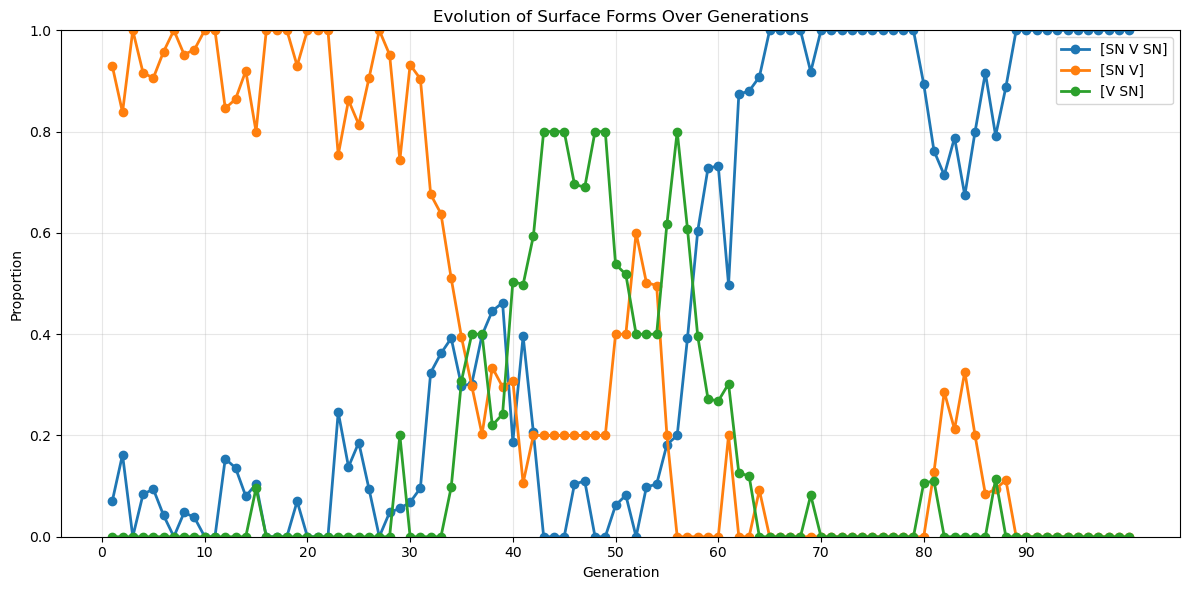

In [215]:
print(f"Agents' initial hierarchies: {model.initial_hierarchies}")
print(f"Agents' updated hierarchies: {model.updated_hierarchies}")
model.plot_history() 

## Multiple simulations

In [ ]:
import multiprocessing as mp
import time

def run_single_simulation_with_progress(args):
    """Run simulation with unpacked arguments and progress tracking."""
    sim_id, params = args
    start_time = time.time()
    
    print(f"Starting simulation {sim_id + 1}/{params['n_total']}...")
    
    model = Model(pop_size=params['pop_size'], 
                  generations=params['generations'],
                  gen0_hierarchy_name=params['gen0_hierarchy_name'],
                  learning_data_size=params['learning_data_size'],
                  productions_per_agent=params['productions_per_agent'],
                  seed=42 + sim_id)
    
    model.run()
    
    elapsed = time.time() - start_time
    print(f"Simulation {sim_id + 1} completed in {elapsed:.1f}s")
    
    return model.production_history

# ----- Parameters -----
n_simulations = 20
params = {
    'pop_size': 5,
    'generations': 100,
    'gen0_hierarchy_name': 'H1',
    'learning_data_size': 30,
    'productions_per_agent': 100,
    'n_total': n_simulations
}

# ----- Run simulations in parallel -----
if __name__ == '__main__':
    n_processes = min(n_simulations, mp.cpu_count())
    print(f"Running {n_simulations} simulations on {n_processes} processes...")
    
    # Prepare arguments for each simulation
    simulation_args = [(i, params) for i in range(n_simulations)]
    
    start_time = time.time()
    with mp.Pool(processes=n_processes) as pool:
        histories = pool.map(run_single_simulation_with_progress, simulation_args)
    
    total_time = time.time() - start_time
    print(f"All simulations completed in {total_time:.1f}s")

Mean Proportions:
[SN V SN SN]    0.0001
[SN V SN]       0.2385
[SN V]          0.5085
[V SN]          0.2529
dtype: float64


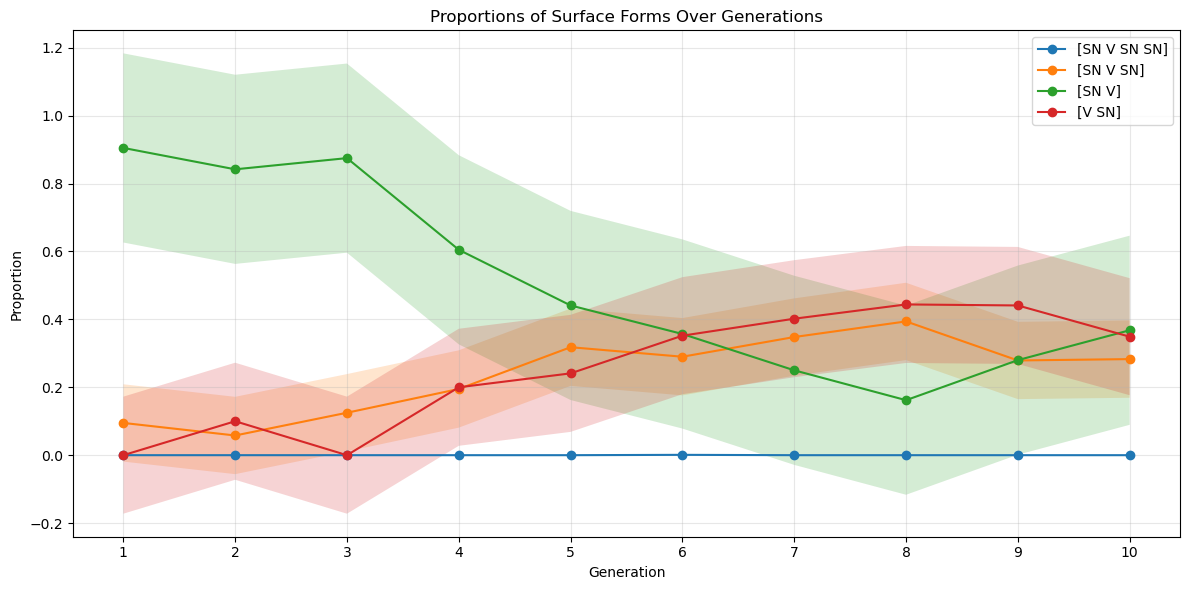

In [ ]:
# ----- Combine results -----
all_generations = {}

for history in histories:
    for gen, productions in history.items():
        if gen not in all_generations:
            all_generations[gen] = []
        all_generations[gen].extend(prettify_sf(sf, flat=True) for sf in productions)

# Convert to DataFrame
all_generations_df = pd.DataFrame(all_generations)

# Count occurrences of each surface form
counts = all_generations_df.apply(lambda x: x.value_counts()).fillna(0) 

# Convert counts to proportions
proportions = counts.apply(lambda x: x / x.sum(), axis=0)

# Calculate mean and std deviation across simulations
mean_proportions = proportions.mean(axis=1)
std_proportions = proportions.std(axis=1)

print(f"Mean Proportions:\n{mean_proportions}")

# ----- Plot aggregate results -----
plt.figure(figsize=(12, 6))

# Get generations (x-axis) from proportions columns
generations = proportions.columns
x_axis = range(len(proportions.columns))

for sf in proportions.index:  # Iterate over surface forms
    sf_proportions = proportions.loc[sf].values  # Get array of proportions across generations
    sf_mean = mean_proportions[sf]  # This is still a single value
    sf_std = std_proportions[sf]   # This is still a single value
    
    plt.plot(x_axis, sf_proportions, label=sf)
    plt.fill_between(x_axis, 
                    sf_proportions - sf_std, 
                    sf_proportions + sf_std, 
                    alpha=0.2)

plt.title("Proportions of Surface Forms Over Generations")
plt.xlabel("Generation")
plt.ylabel("Proportion")
plt.xticks(x_axis, generations)  # Label x-axis with actual generation numbers
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()